# Module _gameoflife_ 

This module contains the core functions needed to generate the initial distribution of the cells, i.e. the initial pattern, and their future evolution controlled by the _Game of life_ rules. \
The module is divided into two submodules, which are _patterns_ and _evolution_.

## Submodule _evolution_

The module _evolution_ consists in two functions, namely _newgen_ and _evolution_. They both deal with 2D numpy arrays, which contains boolean variables: `True` stands for alive cells and `False` stands for dead cells. These numpy arrays represent the 2D grid of the _Game of life_ world in which cells live. 

### Function _newgen_

The function _newgen_ takes in input the current generation of cells and gives in output the next one, calculated through the rules of _Game of life_. Its structure is very simple. 


First, the matrix representing the current generation of cells gets padded in order to identify the borders of the corresponding grid, making a toroidal structure of the world in which they live. Then, since alive and dead cells have to respect different rules, the function creates two different arrays for their indeces: `alive_idx` and `dead_idx`. However, these arrays are traslated with respect to the original grid due to the padding procedure; hence, the function fix this by adding a traslation by [1, 1]. 


Ultimately, there is the actual next generation creation. The old generation matrix gets copied into a new one, which is then modified by the two for cicles that apply the _Game of life_ rules to each cell. The first for cicle make alive cells evolve, whereas the second make the dead cells evolve. 

In [1]:
import numpy as np
import numpy.typing as npt #For writing the data types in the function definition

def newgen(cells: npt.NDArray[np.bool_]):
    #This create a wrapped surface, where top is identified with bottom and left with right
    padded = np.pad(cells, pad_width=1, mode='wrap')
    
    #Extracts the indexes of living cells (True) and dead cells (False)
    alive_idx = np.argwhere(cells == True) 
    dead_idx = np.argwhere(cells == False) 

    #I add [1, 1] in order to traslate the indexes and make them compatible with the padded matrix
    alive_idx += np.array([1, 1])
    dead_idx += np.array([1, 1])

    #Make a copy of the grid, i.e. the next generation (necessary to make the code work)
    newgen = np.copy(cells)

    #Calculates the evolution of the living cells
    for index in alive_idx:
        neig = padded[index[0]-1:index[0]+2, index[1]-1:index[1]+2]
        #The -1 is to delete the cell I am considering from the counts of alive neighbors
        nalive = len(neig[neig == True]) - 1
        if (nalive != 2 and nalive != 3):
            newgen[index[0]-1, index[1]-1] = False

    #Calculates the evolution of the dead cells
    for index in dead_idx:
        neig = padded[index[0]-1:index[0]+2, index[1]-1:index[1]+2]
        #The -1 is to delete the cell I am considering from the counts of alive neighbors
        nalive = len(neig[neig == True]) 
        if (nalive == 3):
            newgen[index[0]-1, index[1]-1] = True

    return newgen

### Function _evolution_

This function takes in input the first generation, i.e. the original pattern, and gives in output the evolution timeline of that original pattern. The number of steps in the timeline is set by the other parameter of the _evolution_ function, which is `timesteps`.  

In [2]:
def evolution(genzero: npt.NDArray[np.bool_], timesteps: int):
    
    # Creates a list containing the configurations for each timestep in the evolution
    timeline = []
    
    # Initialize the current state with the generation zero
    current_state = genzero
    timeline.append(current_state) # Include the starting state in the timeline
    
    # Calculates the configuration for each timestep
    for t in range(timesteps):
        # ERROR FIX: We must use 'current_state' as input, not 'genzero' repeatedly
        new = newgen(cells=current_state)
        
        # Update the current state for the next iteration
        current_state = new
        
        timeline.append(new)
    
    return timeline


## Submodule _patterns_
The module _patterns_ allows the user to insert specific patterns into the grid. It relies on a dictionary called `SEED_DATA` which stores the matrix representation of various patterns, categorized into: `Still Life`, `Oscillator`, `Spaceship`, and `Complex`.

### Function _insert_pattern_
This function places a pattern into the grid at specified coordinates. It handles:
- **Toroidal wrapping**: If a pattern goes off the edge, it wraps around to the other side.
- **Rotation**: The pattern can be rotated 90, 180, or 270 degrees anticlockwise.
- **Flipping**: The pattern can be horizontally flipped.

#### Syntax
```python
insert_pattern(grid, category, name, row_origin, col_origin, rotate=0, flip=False)
```

#### Parameters
- `grid`: NumPy array representing the Game of Life world
- `category`: Pattern category (e.g., "Still Life", "Oscillator")
- `name`: Pattern name (e.g., "Glider", "Pulsar")
- `row_origin`, `col_origin`: Top-left coordinates where the pattern will be placed
- `rotate`: Number of 90° anticlockwise rotations (0-3)
- `flip`: Boolean, if True flips the pattern horizontally

#### Example Usage
```python
import numpy as np
import patterns

# Create a 50x50 grid
grid = np.zeros((50, 50), dtype=int)

# Insert a Glider at position (10, 10)
grid = patterns.insert_pattern(grid, "Spaceship", "Glider", 10, 10)

# Insert a rotated and flipped Pulsar at position (20, 20)
grid = patterns.insert_pattern(grid, "Oscillator", "Pulsar", 20, 20, rotate=1, flip=True)

# Insert a Glider Gun
grid = patterns.insert_pattern(grid, "Complex", "Glider Gun", 5, 5)
```





### Available Patterns
**Notation**: In the ASCII diagrams below, `O` represents a live cell and `.` represents a dead cell.
#### Still Lifes
Stable patterns that remain unchanged over time.

##### Block
```
OO
OO
```
**Size**: 2×2 | **Live cells**: 4

The simplest still life pattern. A perfect 2×2 square where each cell has exactly 3 living neighbors, ensuring stability according to the survival rule.

##### Beehive
```
.OO.
O..O
.OO.
```
**Size**: 3×4 | **Live cells**: 6

A hexagonal shape resembling a beehive. Each living cell has 2-3 neighbors, maintaining perfect stability.

##### Loaf
```
.OO.
O..O
.O.O
..O.
```
**Size**: 4×4 | **Live cells**: 7

Similar to the Beehive but with an asymmetric "tail" that gives it a loaf-like shape. Rows 1-2 resemble a Beehive, while rows 3-4 form the distinctive tail.

---

#### Oscillators
Patterns that return to their initial state after a fixed period.

##### Blinker (Period 2)
```
Horizontal:  OOO    →    Vertical:  .O.
                                    .O.
                                    .O.
```
**Size**: 1×3 (or 3×1) | **Live cells**: 3 | **Period**: 2

The simplest oscillator. Alternates between horizontal and vertical orientations. The center cell survives (2 neighbors), edge cells die (1 neighbor), and new cells are born above and below.

##### Toad (Period 2)
```
..O.
O..O
O..O
.O..
```
**Size**: 4×4 | **Live cells**: 6 | **Period**: 2

This pattern represents the expanded phase of the Toad oscillator, appearing as a hollow diamond-like shape. Every generation, it alternates with its compact phase, which consists of two horizontal bars of three cells offset diagonally. This rhythmic expansion and contraction mimics the movement of a breathing toad.
##### Pulsar (Period 3)
```
...OOO...OOO...
.O....O.O....O.
.O....O.O....O.
.O....O.O....O.
...OOO...OOO...
...............
...OOO...OOO...
.O....O.O....O.
.O....O.O....O.
.O....O.O....O.
...OOO...OOO...
```
**Size**: 13×13 | **Live cells**: 48 | **Period**: 3

A highly symmetric structure with 4 identical "arms" arranged in a cross formation. Each arm pulses through 3 generations, making it one of the most recognizable large oscillators.

##### Pentadecathlon (Period 15)
```
..O....O..
OO.OOOO.OO
..O....O..
```
**Size**: 3×10 | **Live cells**: 12 | **Period**: 15
The Pentadecathlon is a rare and powerful period-15 oscillator, here represented in its most compact 3x10 phase. Its structure consists of a horizontal core of twelve cells: a central row featuring two outer pairs and a four-cell inner bridge, flanked by two "wings" in the rows above and below. Throughout its 15-generation cycle, the pattern undergoes a dramatic evolution, expanding vertically to a height of 9 cells before perfectly contracting back to this initial configuration. Due to its high period and unique geometry, it is frequently used in complex Game of Life constructions as a "reflector" to change the path of traveling gliders.


#### Spaceships
Patterns that translate (move) across the grid over time.

##### Glider
```
.O.
..O
OOO
```
**Size**: 3×3 | **Live cells**: 5 | **Speed**: 1 cell diagonally every 4 generations (c/4) | **Direction**: Down-right (in this orientation)

The Glider is the smallest spaceship. It operates on a period of 4, transitioning through two distinct asymmetrical phases before returning to its original 3x3 diagonal orientation. During each full cycle, the entire structure displaces itself by one cell diagonally. Due to its simplicity and stability, it is the primary means of transmitting information across the grid in complex cellular automata constructions.

##### LWSS (Lightweight Spaceship)
```
.OOOO
O...O
....O
O..O.
```
**Size**: 4×5 | **Live cells**: 9 | **Speed**: 2 cells horizontally every 4 generations (c/2) | **Direction**: Right (in this orientation)

The LWSS is the smallest orthogonally-traveling spaceship, featuring an aerodynamic "head" in the first row followed by a body and tail. It operates on a period of 4, cycling through three intermediate asymmetrical states before returning to its original configuration. During this full cycle, the entire structure shifts 2 cells horizontally across the grid, maintaining a constant speed of c/2. As a foundational pattern, it belongs to the same family as the Medium (MWSS) and Heavy (HWSS) spaceships.

---
#### Complex Patterns




##### **Glider Gun (Gosper)**

```
........................OO..........  <-- Right Stabilizer (Eater/Block)
........................OO..........  <-- Right Stabilizer (Eater/Block)
............OO......................  <-- Queen Bee Shuttle B (Top)
...........O..O.....................  <-- Queen Bee Shuttle B (Top)
OO........O....O..OO................  <-- Left Block + Colliding Shuttles
OO........O...O.O.OO................  <-- Left Block + Colliding Shuttles
..........O....O....................  <-- Queen Bee Shuttle A (Bottom)
...........O..O.....................  <-- Queen Bee Shuttle A (Bottom)
............OO......................  <-- Queen Bee Shuttle A (Bottom)

```

**Size**: 9×36 | **Initial live cells**: 36 | **Period**: 30 | **Output**: 1 Glider every 30 generations

**Description**:
The Gosper Glider Gun was the first discovered pattern capable of infinite growth. It functions as a complex "factory" where two unstable oscillators, known as **Queen Bee shuttles**, collide rhythmically in the center.

**Dynamics and Significance**:

* **Mechanism**: Every 30 generations, the collision between the two shuttles "pinches off" a small cluster of cells that stabilizes into a **Glider**.
* **Stabilization**: The stable **Block patterns** at the edges act as "eaters" or reflectors, cleaning up debris and bouncing the shuttles back to reset the cycle.
* **Turing-Completeness**:By emitting a continuous stream of Gliders, this pattern proves the Game of Life is Turing-complete. Gliders act as data bits (1s and 0s) while their collisions simulate logical gates (AND, OR, NOT), theoretically allowing the system to perform any universal computation. As the gun cycles indefinitely, the grid's population grows linearly, providing the infinite "memory" and signal flow required for a universal computer.
* **Infinite Growth**: Because it emits a new spaceship indefinitely, the total population of the grid increases linearly over time ( Gliders after  generations).

---


### Helper Functions

#### get_available_categories()
Returns a list of all available pattern categories.

```python
categories = patterns.get_available_categories()
print(categories)
# Output: ['Still Life', 'Oscillator', 'Spaceship', 'Complex']
```

#### get_patterns_by_category(category)
Returns the names of all patterns in a specific category.

```python
oscillators = patterns.get_patterns_by_category("Oscillator")
print(oscillators)
# Output: ['Blinker', 'Toad', 'Pulsar', 'Pentadecathlon']

spaceships = patterns.get_patterns_by_category("Spaceship")
print(spaceships)
# Output: ['Glider', 'LWSS']
```

### Complete Example
```python
import numpy as np
import patterns

# Initialize grid
grid = np.zeros((100, 100), dtype=int)

# Discover available patterns
print("Categories:", patterns.get_available_categories())
print("Oscillators:", patterns.get_patterns_by_category("Oscillator"))

# Add various patterns
grid = patterns.insert_pattern(grid, "Still Life", "Block", 10, 10)
grid = patterns.insert_pattern(grid, "Oscillator", "Blinker", 20, 20)
grid = patterns.insert_pattern(grid, "Spaceship", "Glider", 30, 30)
grid = patterns.insert_pattern(grid, "Complex", "Glider Gun", 50, 10)

# Add rotated pattern
grid = patterns.insert_pattern(grid, "Spaceship", "LWSS", 40, 40, rotate=1)
```




---
---

# **GAME OF LIFE ANALYSIS SYSTEM**

This section contains an analytical framework for systematically studying Conway's Game of Life patterns. The system performs automated experiments, calculates physics-based metrics, and generates detailed visual reports.

## **System Architecture**

The analysis framework is organized into four main components:

1. **Configuration Suite** - Defines the experimental test battery
2. **Core Analytics Engine** - Executes simulations and computes metrics
3. **Reporting Engine** - Generates visual reports
4. **Main Execution Pipeline** - Orchestrates the entire analysis workflow

---

## **1. Configuration Suite**

The `TEST_SUITE` defines a battery of experiments covering different pattern categories:

- **Still Life**: Patterns that never change (e.g., Block)
- **Oscillators**: Patterns with periodic behavior (e.g., Blinker, Pulsar)
- **Spaceships**: Patterns that translate across the grid (e.g., Glider)
- **Complex Patterns**: Advanced structures with emergent behavior (e.g., Gosper Glider Gun)
- **Random Configurations**: Chaotic initial conditions for entropy analysis

Each experiment specifies:
- Pattern name and category
- Initial position on the grid
- Number of simulation steps
- Grid dimensions

---

## **2. Core Analytics Engine**

The `SimulationRunner` class implements analysis methods:

### **Spatial Metrics**
- **Center of Mass Calculation**: Tracks the geometric centroid of all living cells
- **Displacement Measurement**: Computes total movement between initial and final states
- **Trajectory Mapping**: Records the complete path of pattern movement

### **Temporal Metrics**
- **Period Detection**: Identifies repeating states using backward timeline analysis
- **Activity Flux**: Measures the number of cell state changes per generation
- **Population Dynamics**: Tracks birth/death rates and total cell count evolution

### **Information Theory Metrics**
- **Shannon Entropy**: Quantifies the spatial complexity of cell distribution
- **Occupancy Heatmaps**: Visualizes temporal cell density patterns

### **Behavioral Classification**
An heuristic system that classifies patterns into:
- **Still Life**: Period = 1, no displacement
- **Oscillator**: Period > 1, minimal displacement
- **Spaceship/Mover**: Period > 1, significant displacement
- **Unbounded Growth**: Continuous population increase (e.g., guns)
- **Chaotic/Complex**: No detectable period, stabilizing dynamics
- **Extinction**: All cells die

---

## **3. Reporting Engine**

The `generate_report()` function creates publication-quality visual reports with:

### **Multi-Panel Layout** (2×3 grid)
1. **Population Evolution Chart**: Time series of living cell count
2. **Center of Mass Trajectory**: Spatial path visualization with start/end markers
3. **Entropy & Activity Dual-Axis Plot**: Information complexity and flux dynamics
4. **Occupancy Heatmap**: Cumulative cell density visualization
5. **Technical Data Card**: Summary statistics and classification results

### **Statistical Outputs**
- Initial and final population
- Peak occupancy percentage
- Peak entropy value
- Average activity (flux)
- Detected period
- Net displacement
- Behavioral classification

---

## **4. Main Execution Pipeline**

The main workflow:
1. Creates the output directory for reports
2. Iterates through all experiments in the test suite
3. Executes each simulation with full metric collection
4. Generates and saves individual reports
5. Provides error handling and progress tracking

---

## **1. CONFIGURATION SUITE**

This section defines all experiments to be executed. Each configuration specifies:
- **name**: Unique identifier for the experiment
- **category**: Pattern type classification
- **pattern_name**: Specific pattern from the patterns module
- **pos**: Initial (row, col) position on the grid
- **steps**: Number of generations to simulate
- **grid_size**: Dimensions of the simulation world

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import gameoflife.evolution as cg
import gameoflife.patterns as pt

# ==========================================
# 1. CONFIGURATION SUITE
# ==========================================
# Define here all the experiments you want to run.
# The system will iterate through this list and generate a report for each.
# ==========================================

TEST_SUITE = [
    {
        "name": "Block_Stability",
        "category": "Still Life",
        "pattern_name": "Block",
        "pos": (25, 25),
        "steps": 50,
        "grid_size": (50, 50)
    },
    {
        "name": "Blinker_Oscillation",
        "category": "Oscillator",
        "pattern_name": "Blinker",
        "pos": (25, 25),
        "steps": 50,
        "grid_size": (50, 50)
    },
    {
        "name": "Pulsar_Oscillation",
        "category": "Oscillator",
        "pattern_name": "Pulsar",
        "pos": (20, 20),
        "steps": 100,
        "grid_size": (60, 60)
    },
    {
        "name": "Glider_Trajectory",
        "category": "Spaceship",
        "pattern_name": "Glider",
        "pos": (5, 5),
        "steps": 100,
        "grid_size": (60, 60)
    },
    {
        "name": "Gosper_Gun_Growth",
        "category": "Complex",
        "pattern_name": "Glider Gun",
        "pos": (5, 5),
        "steps": 150,
        "grid_size": (60, 80)
    },
    {
        "name": "Random_Entropy",
        "category": "Random",
        "pattern_name": "Random",
        "pos": (0, 0),
        "steps": 200,
        "grid_size": (80, 80)
    }
]

OUTPUT_DIR = "Analysis"

## **2. CORE ANALYTICS ENGINE**

The `SimulationRunner` class encapsulates all physics calculations and simulation logic.

### **Class Methods Overview:**

#### **Spatial Analysis Methods:**
- `get_center_of_mass(grid)`: Calculates the geometric centroid of all living cells

#### **Temporal Analysis Methods:**
- `detect_period(timeline)`: Identifies periodic behavior by backward state comparison

#### **Classification Methods:**
- `classify_behavior(period, displacement, population_trend)`: Heuristic pattern classification

#### **Information Theory Methods:**
- `calculate_entropy(grid)`: Computes Shannon entropy of spatial distribution

#### **Main Execution Method:**
- `run(config)`: Orchestrates the complete simulation and data collection pipeline

In [4]:
# ==========================================
# 2. CORE ANALYTICS ENGINE
# ==========================================

class SimulationRunner:
    """
    Encapsulates the logic for running simulations and calculating physics metrics.
    """

    @staticmethod
    def get_center_of_mass(grid):
        """
        Calculates the spatial center of mass of alive cells.
        Returns (row, col). Returns (NaN, NaN) if grid is empty.
        """
        indices = np.argwhere(grid)         # Find indices (row, col) of alive cells
        if indices.size == 0:
            return np.nan, np.nan
        mean_pos = np.mean(indices, axis=0) # Mean of each column (rows, cols)
        return mean_pos[0], mean_pos[1]

    @staticmethod
    def detect_period(timeline):
        """
        Analyzes the timeline backwards to find repeating patterns.
        Returns period (int) or -1 if chaotic/transient.
        """
        last_state = timeline[-1]
        n_steps = len(timeline)
        
        # Look backwards from the second-to-last frame
        # We limit the search to avoid performance issues on very long simulations
        search_limit = min(n_steps, 200)
        
        for i in range(n_steps - 2, n_steps - 2 - search_limit, -1):
            if i < 0: break
            if np.array_equal(last_state, timeline[i]):
                return (n_steps - 1) - i
        return -1

    @staticmethod
    def classify_behavior(period, displacement, population_trend):
        """
        Heuristic function to classify the pattern based on observed metrics.
        """
        start_pop, end_pop = population_trend
        
        if end_pop == 0:
            return "Extinction"
        
        if period == 1:
            return "Still Life (Stable)"
        
        if period > 1:
            if displacement > 2.0: # Threshold for movement
                return f"Spaceship / Mover (Period {period})"
            else:
                return f"Oscillator (Period {period})"
        
        # If no period detected
        if end_pop > start_pop * 1.5:
            return "Unbounded Growth / Gun"
        
        return "Chaotic / Complex Stabilization"

    @staticmethod
    def calculate_entropy(grid):
        """
        Calculates the Shannon Entropy of the spatial distribution of the grid.
        """
        # Calculate neighbor counts for all active cells
        padded = np.pad(grid, pad_width=1, mode='wrap')
        neighbors = np.zeros_like(grid, dtype=int)
        
        # Sum all 8 neighbors
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                if i == 0 and j == 0: continue
                # Slice and add
                neighbors += padded[1+i:1+i+grid.shape[0], 1+j:1+j+grid.shape[1]]
        
        # Compute histogram of neighbor counts (0 to 8)
        counts = np.bincount(neighbors.flatten(), minlength=9)
        
        # Normalize to probability distribution
        total = np.sum(counts)
        if total == 0: return 0.0
        
        probs = counts / total
        
        # Filter zero probabilities to avoid log(0)
        probs = probs[probs > 0]
        
        # Shannon Entropy: -Sum(p * log2(p))
        entropy = -np.sum(probs * np.log2(probs))
        return entropy

    @staticmethod
    def run(config):
        """
        Executes a single experiment configuration.
        """
        name = config["name"]
        cat = config["category"]
        p_name = config["pattern_name"]
        rows, cols = config["grid_size"]
        steps = config["steps"]
        
        print(f"[{name}] Initializing grid ({rows}x{cols})...")

        # --- A. Setup Grid ---
        grid = np.zeros((rows, cols), dtype=bool)
        
        # Inject pattern
        r_start, c_start = config["pos"]
        grid = pt.insert_pattern(grid, cat, p_name, r_start, c_start)

        # --- B. Evolution Loop ---
        print(f"[{name}] Simulating {steps} generations...")
        timeline = cg.evolution(genzero=grid, timesteps=steps)

        # --- C. Data Collection ---
        results = {
            "config": config,
            "population": [],
            "occupancy": [],
            "com_x": [],
            "com_y": [],
            "entropy": [],
            "activity": [],
            "heatmap": np.zeros((rows, cols), dtype=int),
            "displacement": 0.0
        }
        
        total_pixels = rows * cols
        prev_state = None

        for state in timeline:
            # 1. Population Metrics
            pop = np.sum(state)
            results["population"].append(pop)
            results["occupancy"].append(pop / total_pixels)
            
            # 2. Spatial Metrics (Center of Mass)
            r, c = SimulationRunner.get_center_of_mass(state)
            results["com_y"].append(r) # Row index maps to Y
            results["com_x"].append(c) # Col index maps to X

            # 3. Entropy: Measure of spatial distribution complexity
            ent = SimulationRunner.calculate_entropy(state)
            results["entropy"].append(ent)
            
            # 4. Activity (Flux): Total number of cell state changes from previous step
            if prev_state is None:
                flux = 0
            else:
                flux = np.sum(np.logical_xor(state, prev_state))    # XOR logic: True only if state changed
            results["activity"].append(flux)
            prev_state = state
            
            # 5. Heatmap Accumulation: Number of cells that are alive at each position
            results["heatmap"] += state.astype(int)

        # --- D. Post-Processing Analysis ---
        results["period"] = SimulationRunner.detect_period(timeline)
        
        # Calculate net displacement
        if not np.isnan(results["com_x"][0]) and not np.isnan(results["com_x"][-1]):
            dx = results["com_x"][-1] - results["com_x"][0]
            dy = results["com_y"][-1] - results["com_y"][0]
            results["displacement"] = np.sqrt(dx**2 + dy**2)
        
        # Determine behavior type
        pop_trend = (results["population"][0], results["population"][-1])
        results["behavior"] = SimulationRunner.classify_behavior(
            results["period"], 
            results["displacement"], 
            pop_trend
        )

        return results

## **3. REPORTING ENGINE**

The reporting system generates visual summaries of each experiment.

### **Report Structure:**

The multi-panel layout includes:

1. **Population Evolution** (Top Left): Time series plot showing the number of living cells
2. **Center of Mass Trajectory** (Bottom Left): 2D path visualization with start/end markers
3. **Entropy & Activity** (Top Middle): Dual-axis plot showing information complexity and flux
4. **Occupancy Heatmap** (Bottom Middle): Cumulative density visualization
5. **Technical Data Card** (Right): Summary statistics and classification

Each report is saved as a high-resolution PNG file in the `Analysis` directory.

In [ ]:
# ==========================================
# 3. REPORTING ENGINE
# ==========================================

def generate_report(data, output_folder):
    """
    Creates a detailed visual report and saves it to the disk.
    Includes Population, Trajectory, Entropy, Activity, and Heatmaps.
    """
    name = data["config"]["name"]
    filename = os.path.join(output_folder, f"report_{name}.png")
    
    # Create a figure with a grid layout (2 rows, 3 columns)
    # Col 1: Pop, Trajectory
    # Col 2: Entropy/Activity, Heatmap
    # Col 3: Stats
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.4])

    # --- Plot 1: Population History (Top Left) ---
    ax_pop = fig.add_subplot(gs[0, 0])
    ax_pop.plot(data["population"], color='#2E86C1', linewidth=2, label='Alive Cells')
    ax_pop.set_title("Population Evolution", fontweight='bold')
    ax_pop.set_ylabel("Count")
    ax_pop.legend(loc='upper right')
    ax_pop.grid(True, alpha=0.3)

    # --- Plot 2: Trajectory Map (Bottom Left) ---
    ax_traj = fig.add_subplot(gs[1, 0])
    
    # Plot path
    ax_traj.plot(data["com_x"], data["com_y"], color='#E74C3C', alpha=0.5, label='Path')
    
    # Plot Start and End points
    if len(data["com_x"]) > 0:
        ax_traj.scatter(data["com_x"][0], data["com_y"][0], c='green', s=100, marker='^', label='Start')
        ax_traj.scatter(data["com_x"][-1], data["com_y"][-1], c='red', s=100, marker='s', label='End')
    
    ax_traj.set_title("Center of Mass Trajectory")
    ax_traj.set_xlabel("Grid Column")
    ax_traj.set_ylabel("Grid Row")
    ax_traj.invert_yaxis() # Important for matrix visualization -> index (0,0) is top-left
    ax_traj.legend()
    ax_traj.grid(True, alpha=0.3)

    # --- Plot 3: Entropy & Activity (Top Middle) ---
    ax_ent = fig.add_subplot(gs[0, 1])
    
    # Dual axis
    color_ent = 'tab:purple'
    ax_ent.set_xlabel('Step')
    ax_ent.set_ylabel('Shannon Entropy', color=color_ent)
    ax_ent.plot(data["entropy"], color=color_ent, linewidth=2, linestyle='--')
    ax_ent.tick_params(axis='y', labelcolor=color_ent)
    ax_ent.set_title("Entropy & Activity (Flux)")
    
    ax_act = ax_ent.twinx()
    color_act = 'tab:orange'
    ax_act.set_ylabel('Activity (Flux)', color=color_act)
    ax_act.plot(data["activity"], color=color_act, linewidth=2, alpha=0.7)
    ax_act.tick_params(axis='y', labelcolor=color_act)

    # --- Plot 4: Occupancy Heatmap (Bottom Middle) ---
    ax_heat = fig.add_subplot(gs[1, 1])
    
    # Use log scale if there's huge variance, but linear is usually fine for short runs
    # Adding 1 to avoid log(0) issues if using LogNorm, but let's stick to linear for now.
    im = ax_heat.imshow(data["heatmap"], cmap='hot', interpolation='nearest')
    ax_heat.set_title("Occupancy Heatmap")
    fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)

    # --- Panel 5: Technical Data Card (Right Column) ---
    ax_info = fig.add_subplot(gs[:, 2])
    ax_info.axis('off')
    
    # Calculate new stats
    peak_entropy = max(data["entropy"]) if data["entropy"] else 0
    avg_activity = np.mean(data["activity"]) if data["activity"] else 0
    
    # Construct the text block
    cfg = data["config"]
    text_content = (
        f"EXPERIMENT REPORT: {name}\n"
        f"{'='*30}\n\n"
        f"CONFIGURATION:\n"
        f"• Pattern: {cfg['pattern_name']}\n"
        f"• Category: {cfg['category']}\n"
        f"• Grid Size: {cfg['grid_size']}\n"
        f"• Steps: {cfg['steps']}\n\n"
        f"STATISTICS:\n"
        f"• Initial Pop: {data['population'][0]}\n"
        f"• Final Pop: {data['population'][-1]}\n"
        f"• Peak Occupancy: {max(data['occupancy'])*100:.2f}%\n"
        f"• Peak Entropy: {peak_entropy:.2f}\n"
        f"• Avg Activity: {avg_activity:.1f} cells/step\n\n"
        f"PHYSICS ANALYSIS:\n"
        f"• Period Detected: {data['period'] if data['period'] > 0 else 'None'}\n"
        f"• Net Displacement: {data['displacement']:.2f} px\n"
        f"• Classification: \n  {data['behavior']}"
    )
    
    # Add text box
    ax_info.text(0.05, 0.95, text_content, 
                 fontsize=11, family='monospace', verticalalignment='top',
                 bbox=dict(boxstyle="round,pad=1", facecolor="#F8F9F9", edgecolor="#B2BABB"))

    # Save and Close
    plt.tight_layout()
    plt.savefig(filename, dpi=100)
    plt.close(fig) # Close to free up memory
    print(f"Saved report: {filename}")

## **4. MAIN EXECUTION PIPELINE**

This section orchestrates the complete analysis workflow:

1. **Directory Setup**: Creates the output directory if it doesn't exist
2. **Experiment Iteration**: Loops through all configurations in the test suite
3. **Simulation Execution**: Runs each experiment and collects all metrics
4. **Report Generation**: Creates and saves visual reports for each experiment
5. **Error Handling**: Catches and logs any exceptions during execution

**Usage:**
Simply run this cell to execute all experiments and generate reports. Results will be saved in the `Analysis` directory.

In [6]:
# ==========================================
# 4. MAIN EXECUTION
# ==========================================

# 1. Prepare Output Directory
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created directory: {OUTPUT_DIR}")

print(f"Starting Analysis Suite with {len(TEST_SUITE)} experiments...")

# 2. Loop through experiments
for config in TEST_SUITE:
    try:
        # Run Simulation
        result_data = SimulationRunner.run(config)
        
        # Generate Report
        generate_report(result_data, OUTPUT_DIR)
        
    except Exception as e:
        print(f"ERROR processing {config['name']}: {e}")

print("\nAll experiments completed. Check the 'Analysis' folder.")

Starting Analysis Suite with 6 experiments...
[Block_Stability] Initializing grid (50x50)...
[Block_Stability] Simulating 50 generations...
Saved report: Analysis\report_Block_Stability.png
[Blinker_Oscillation] Initializing grid (50x50)...
[Blinker_Oscillation] Simulating 50 generations...
Saved report: Analysis\report_Blinker_Oscillation.png
[Pulsar_Oscillation] Initializing grid (60x60)...
[Pulsar_Oscillation] Simulating 100 generations...
Saved report: Analysis\report_Pulsar_Oscillation.png
[Glider_Trajectory] Initializing grid (60x60)...
[Glider_Trajectory] Simulating 100 generations...
Saved report: Analysis\report_Glider_Trajectory.png
[Gosper_Gun_Growth] Initializing grid (60x80)...
[Gosper_Gun_Growth] Simulating 150 generations...
Saved report: Analysis\report_Gosper_Gun_Growth.png
[Random_Entropy] Initializing grid (80x80)...
[Random_Entropy] Simulating 200 generations...
Saved report: Analysis\report_Random_Entropy.png

All experiments completed. Check the 'Analysis' folder.

## **5. REPORT VISUALIZATION**

The following cell displays all generated analysis reports.

Displaying Analysis Reports:

Report: report_Block_Stability.png


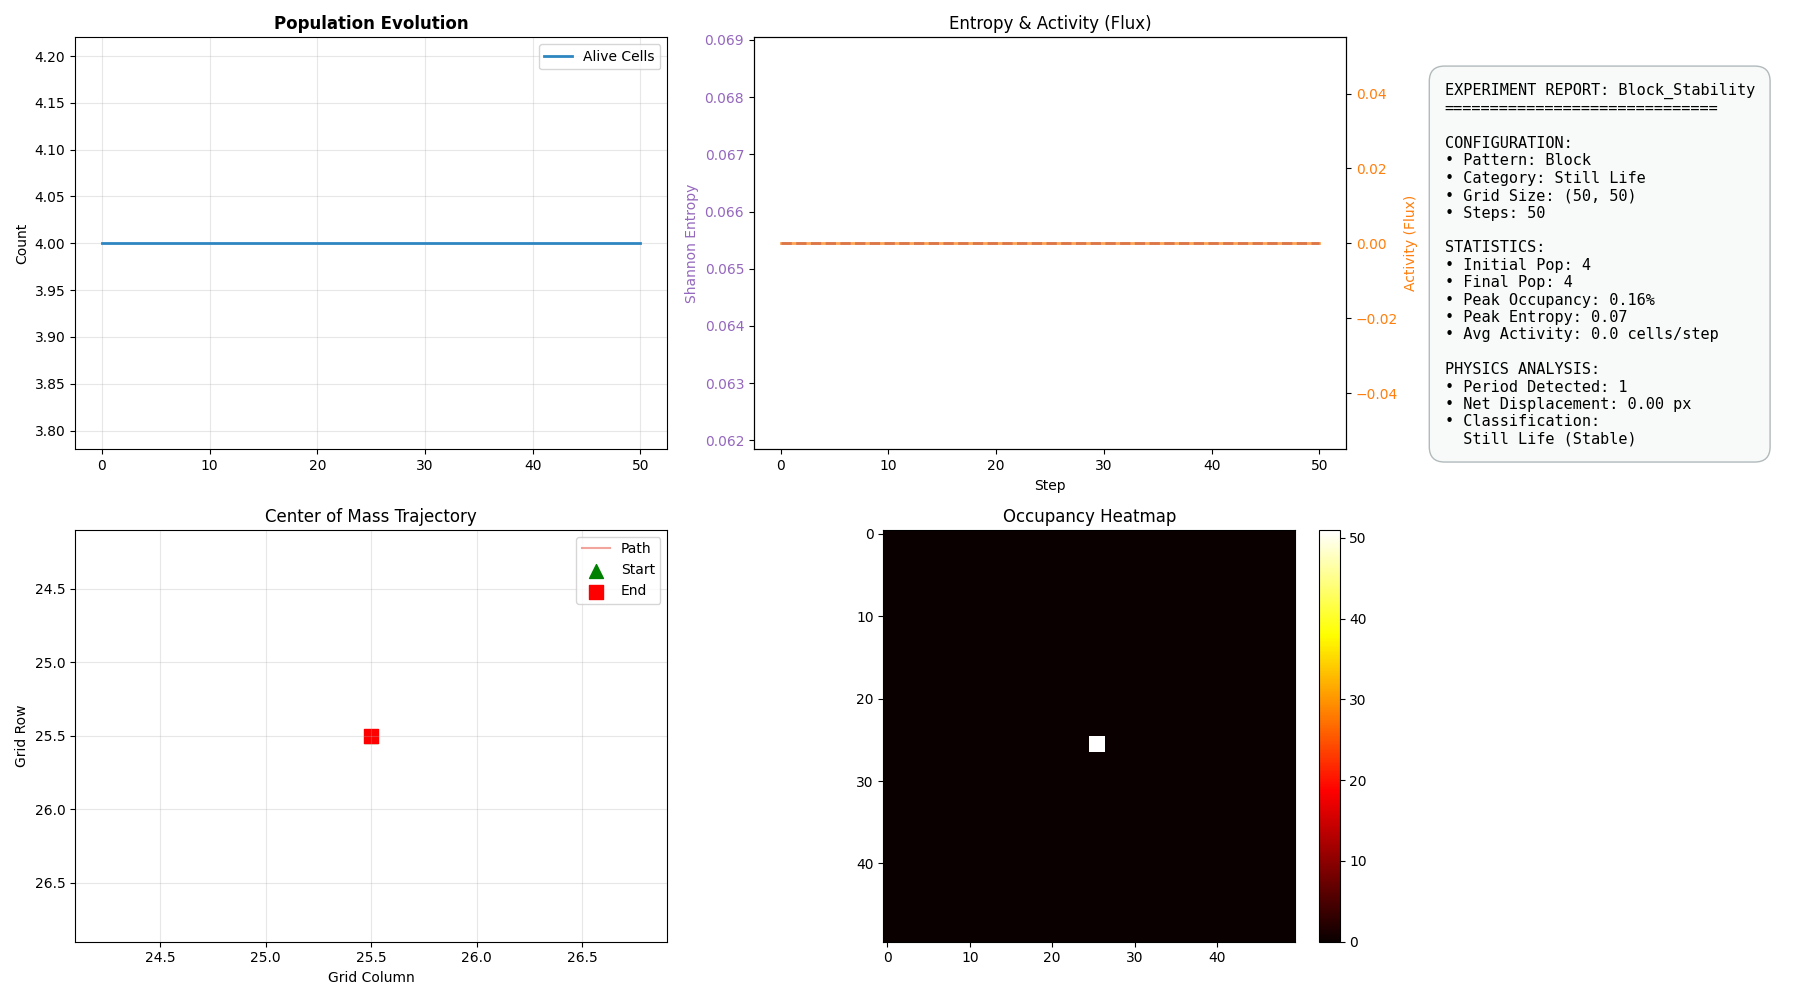


Report: report_Blinker_Oscillation.png


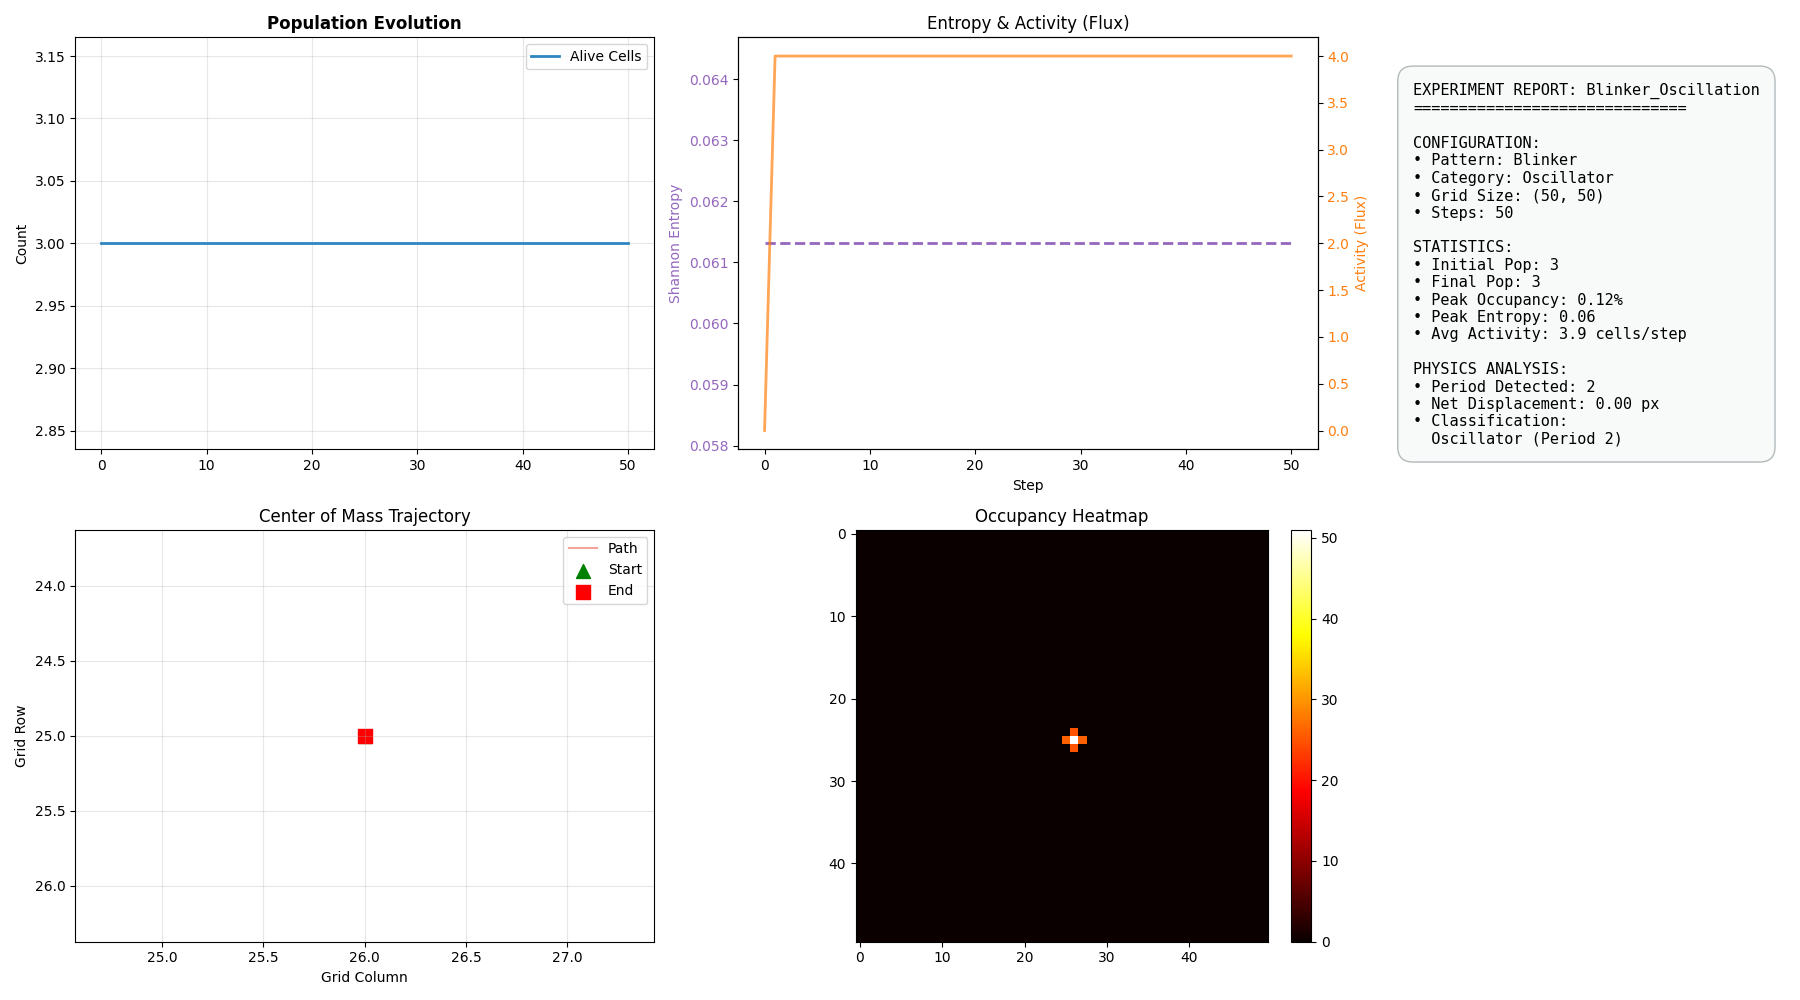


Report: report_Pulsar_Oscillation.png


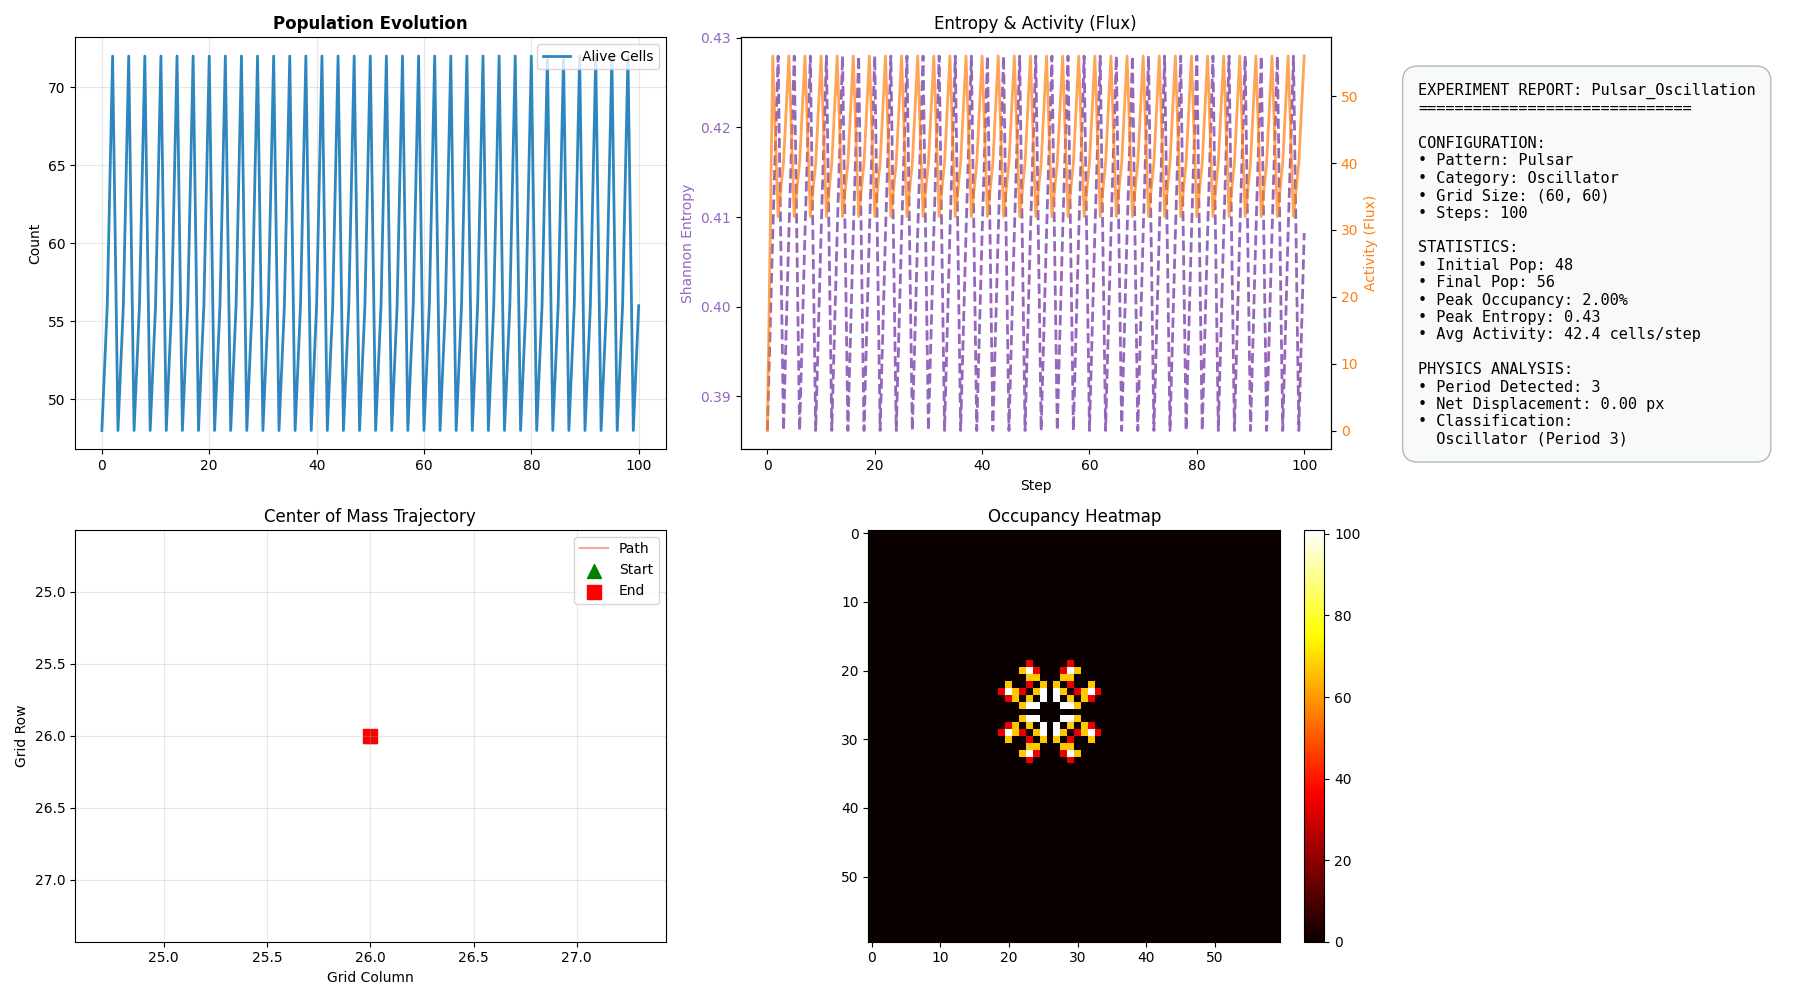


Report: report_Glider_Trajectory.png


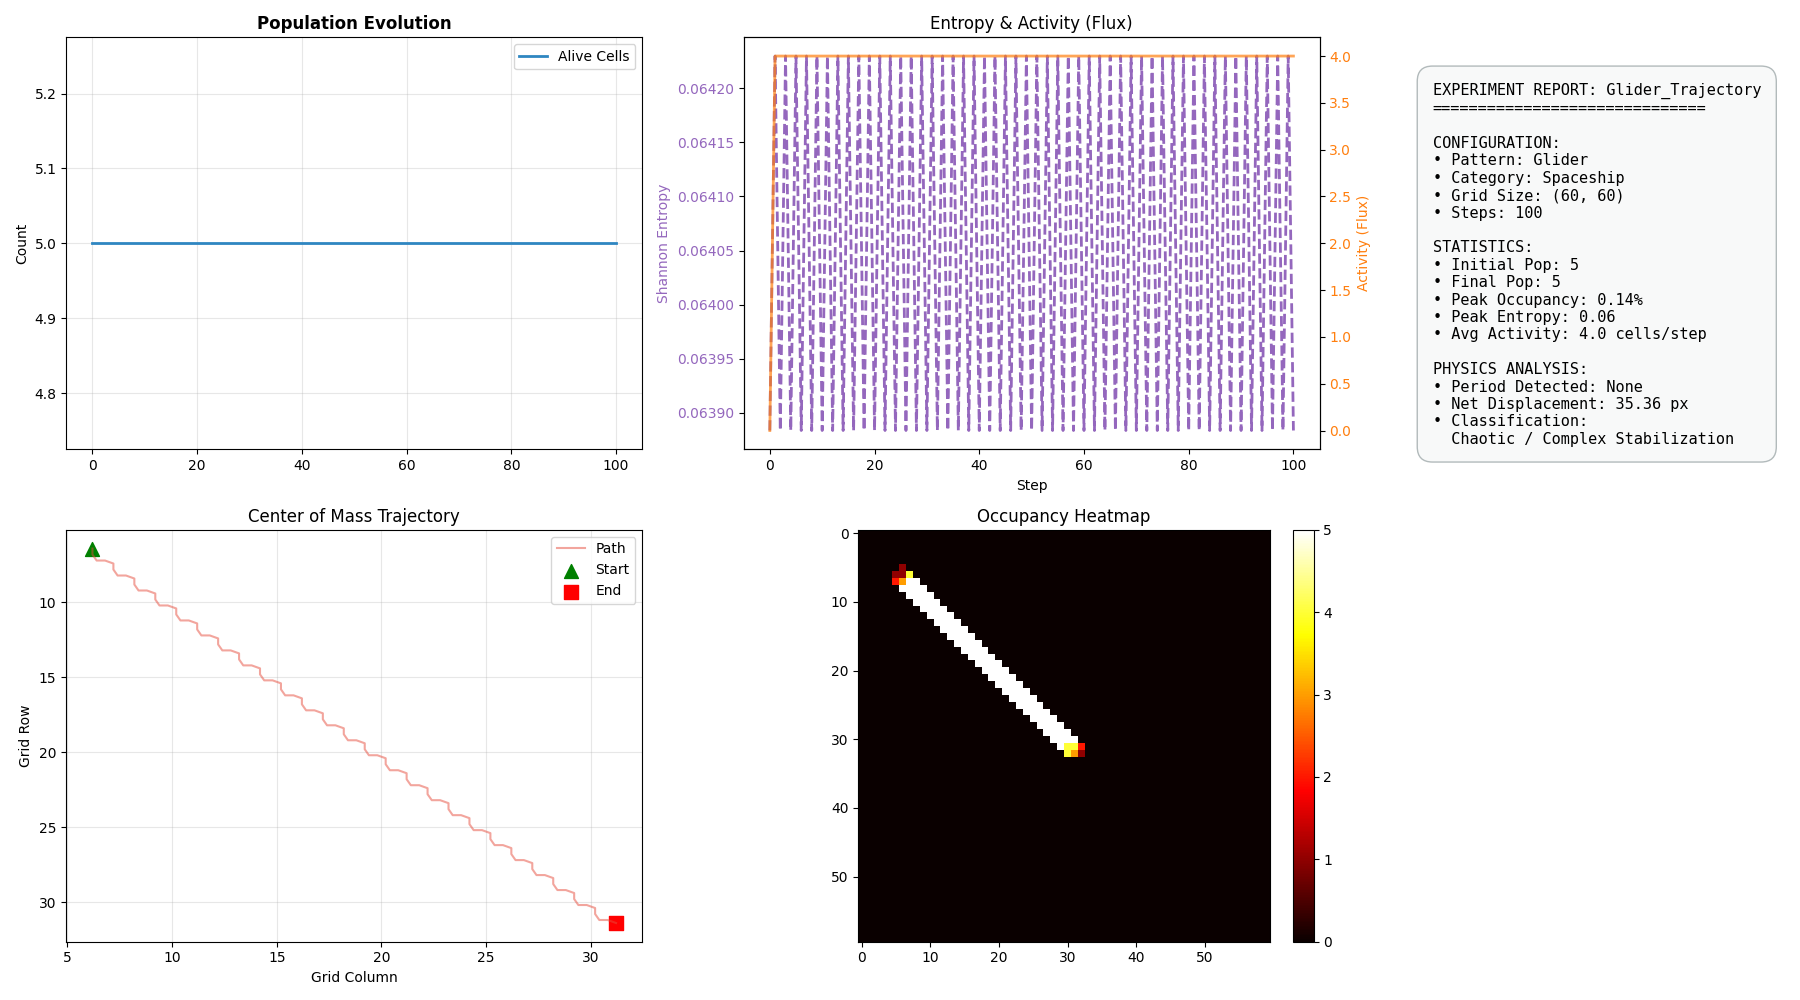


Report: report_Gosper_Gun_Growth.png


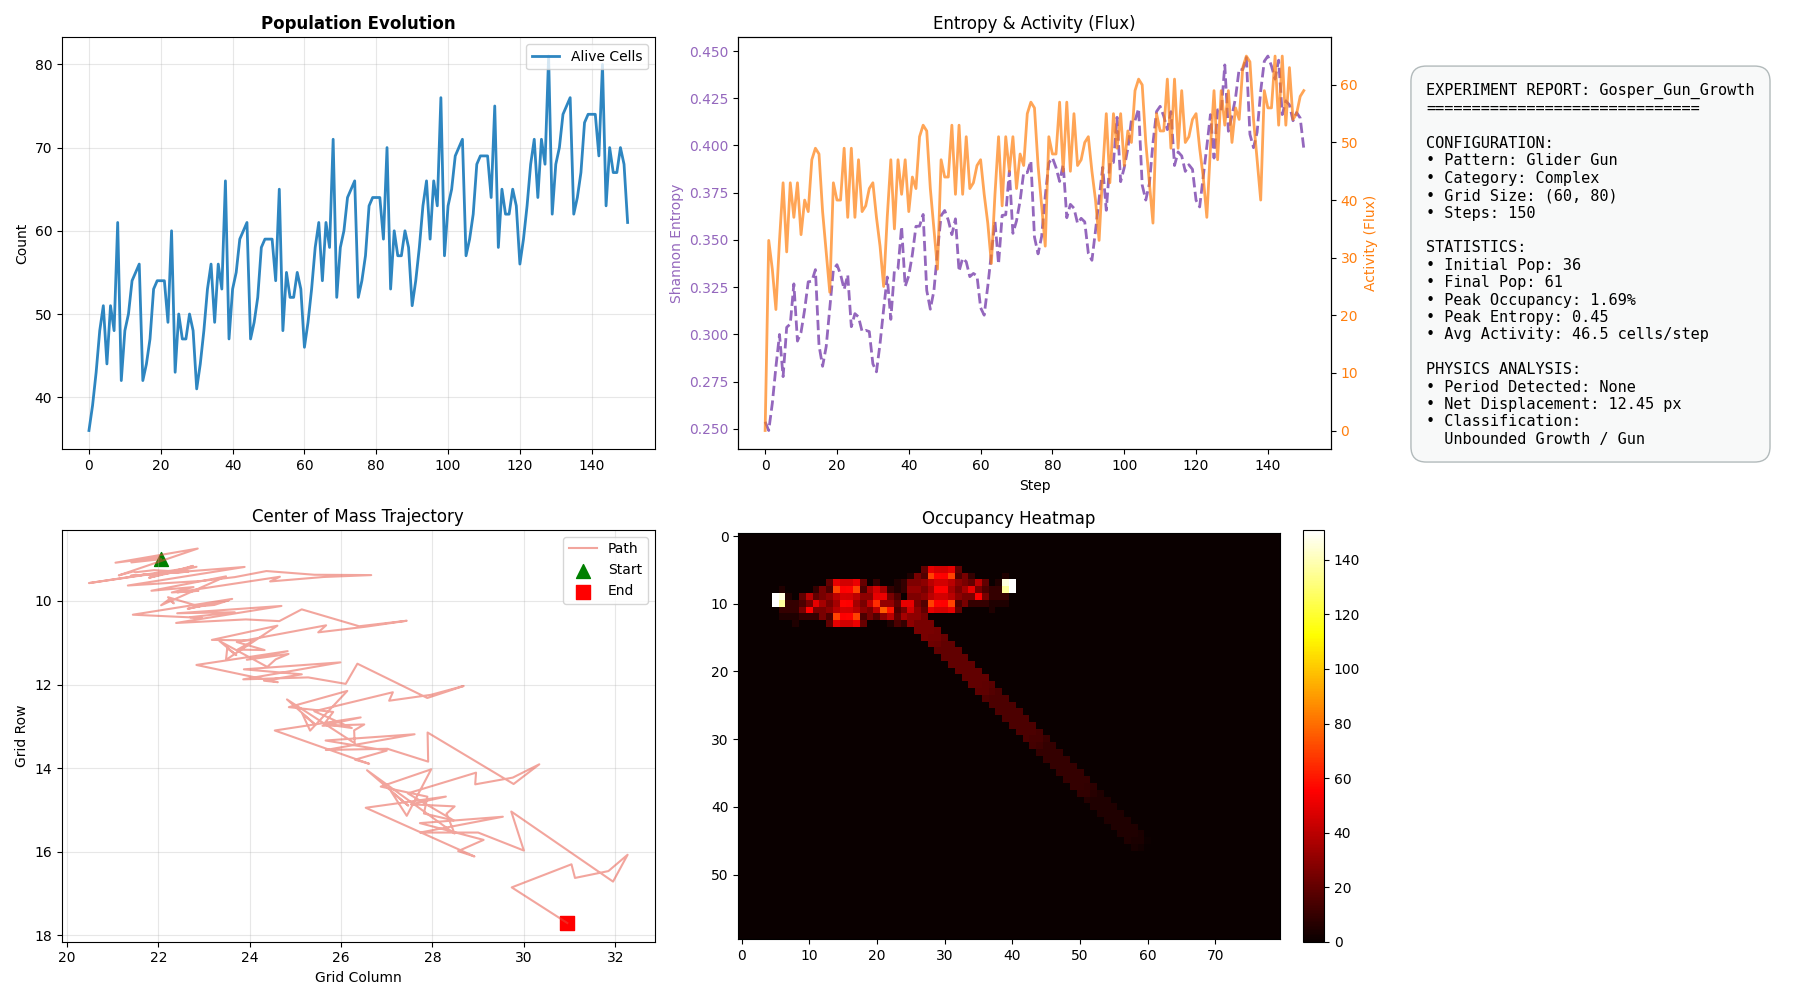


Report: report_Random_Entropy.png


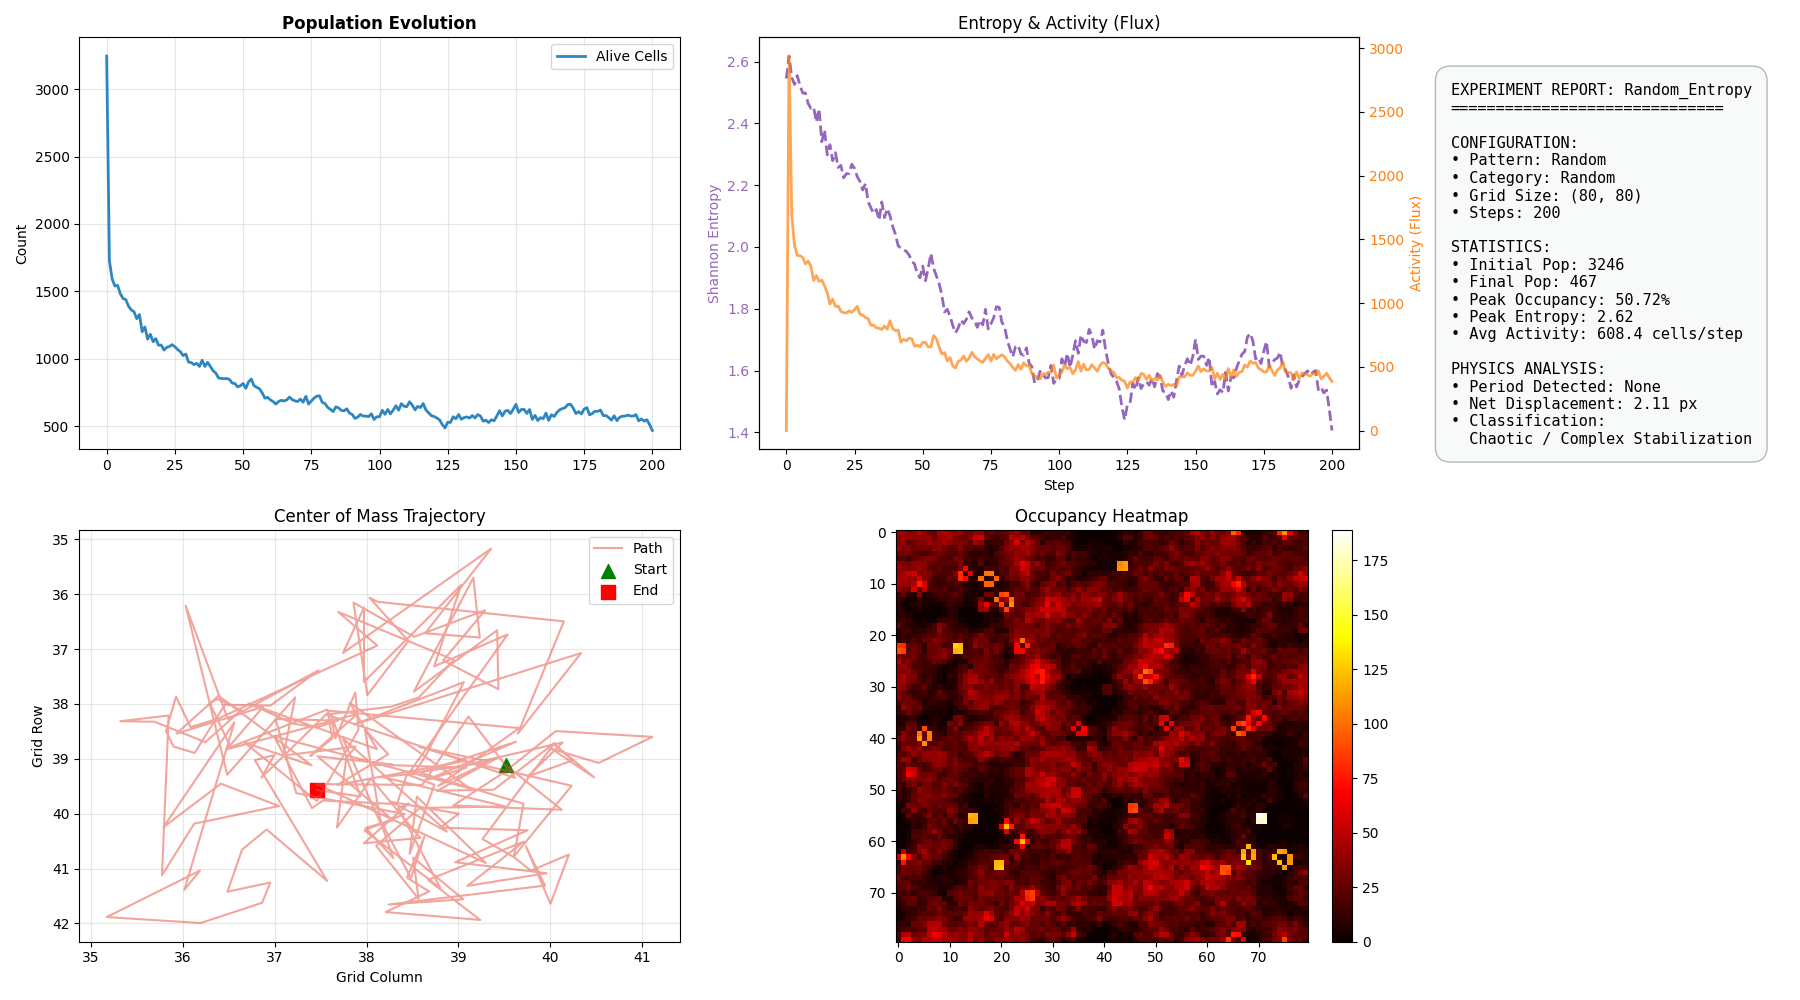

In [7]:
from IPython.display import Image, display
import os

# Define the directory containing the analysis reports
output_dir = "Analysis"

# List of expected report files based on the configuration suite
report_files = [
    "report_Block_Stability.png",
    "report_Blinker_Oscillation.png",
    "report_Pulsar_Oscillation.png",
    "report_Glider_Trajectory.png",
    "report_Gosper_Gun_Growth.png",
    "report_Random_Entropy.png"
]

print("Displaying Analysis Reports:")
print("============================")

for filename in report_files:
    filepath = os.path.join(output_dir, filename)
    if os.path.exists(filepath):
        print(f"\nReport: {filename}")
        display(Image(filename=filepath))
    else:
        print(f"\nReport not found: {filename} (Run the analysis first)")